In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import layers

import matplotlib.pyplot as plt
import numpy as np
import random

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

2025-05-27 16:16:54.914177: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748362615.097676      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748362615.151784      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (32, 32, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 15

# AUGMENTATION
IMAGE_SIZE = 48  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [4]:
#loading CIFAR-10 dataset instead of the given dataset as easy to load and less number of parameters 

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
(x_train, y_train), (x_val, y_val) = (
    (x_train[:40000], y_train[:40000]),
    (x_train[40000:], y_train[40000:]),
)
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Testing samples: {len(x_test)}")

train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step
Training samples: 40000
Validation samples: 10000
Testing samples: 10000


I0000 00:00:1748362641.723739      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [5]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        ],
        name="test_data_augmentation",
    )
    return model


In [6]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

Index selected: 38.


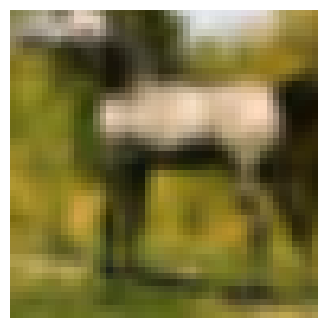

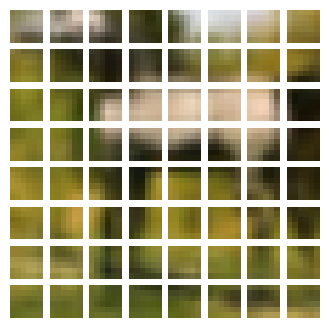

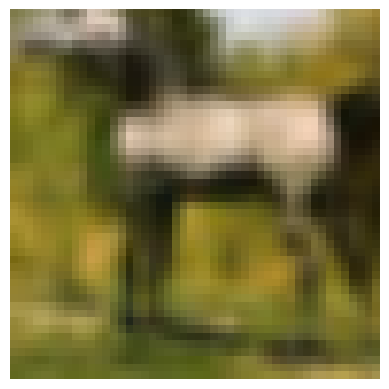

In [7]:
# Get a batch of images.
image_batch = next(iter(train_ds))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [8]:
#masking
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

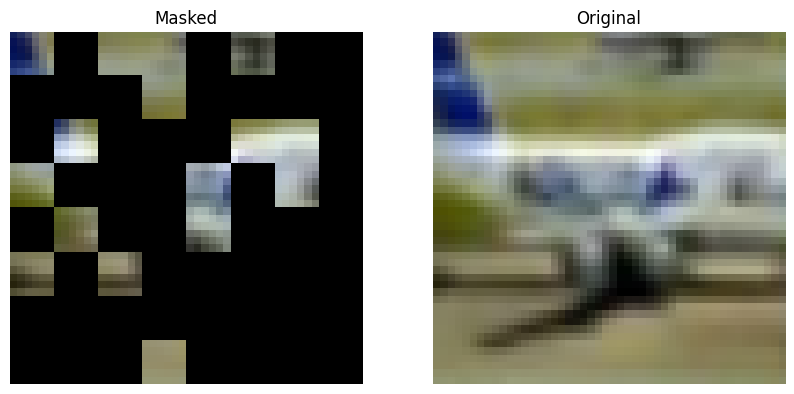

In [9]:
#visualize 
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [10]:
# model MAE from here 

In [11]:
#fully connected layer
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
    

In [12]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [13]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


In [14]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compute_loss(y=loss_patch, y_pred=loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for grad, var in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

In [15]:
# initialize model

In [16]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [17]:
#Visualization callback
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

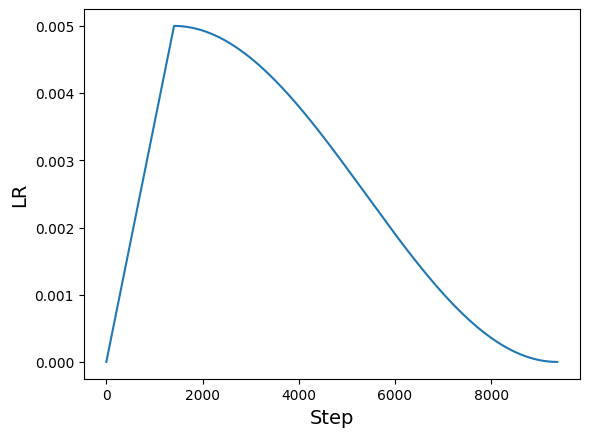

In [18]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - mae: 0.1761 - loss: 0.5015
Idx chosen: 28


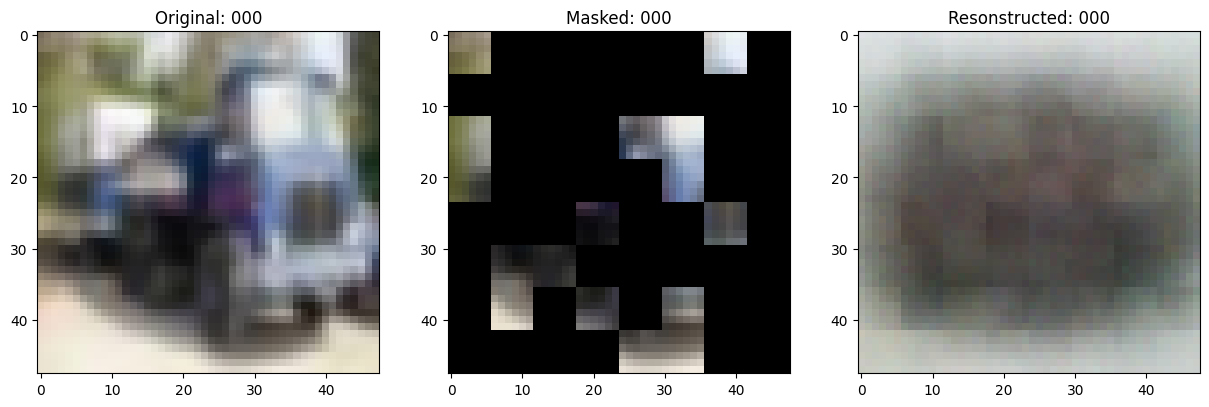

625/625 ━━━━━━━━━━━━━━━━━━━━ 91s 69ms/step - mae: 0.1760 - loss: 0.5015 - val_loss: 0.5378
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.1371 - loss: 0.5290 - val_loss: 0.5405
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.1273 - loss: 0.5372 - val_loss: 0.5431
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.1170 - loss: 0.5449 - val_loss: 0.5546
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.1116 - loss: 0.5487 - val_loss: 0.5575
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - mae: 0.1080 - loss: 0.5504
Idx chosen: 14


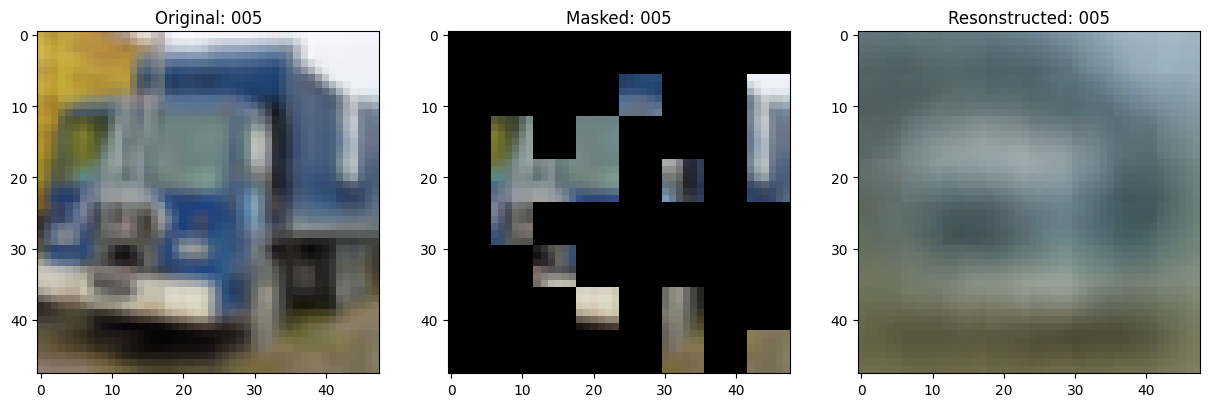

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - mae: 0.1080 - loss: 0.5504 - val_loss: 0.5605
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.1054 - loss: 0.5525 - val_loss: 0.5632
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.1034 - loss: 0.5535 - val_loss: 0.5585
Epoch 9/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - mae: 0.1014 - loss: 0.5551 - val_loss: 0.5617
Epoch 10/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - mae: 0.1000 - loss: 0.5563 - val_loss: 0.5609
Epoch 11/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - mae: 0.0983 - loss: 0.5567
Idx chosen: 42


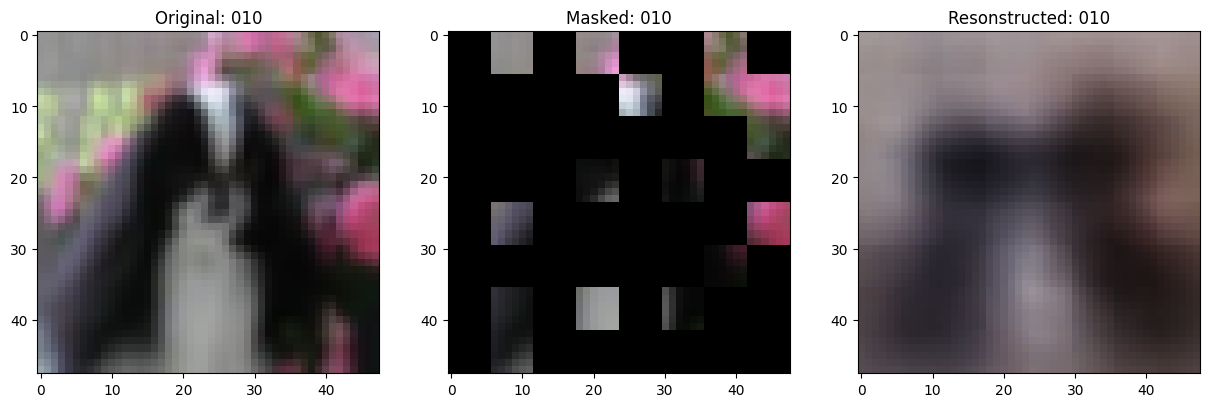

625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 66ms/step - mae: 0.0983 - loss: 0.5567 - val_loss: 0.5635
Epoch 12/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 40s 65ms/step - mae: 0.0970 - loss: 0.5574 - val_loss: 0.5628
Epoch 13/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.0959 - loss: 0.5578 - val_loss: 0.5644
Epoch 14/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.0951 - loss: 0.5590 - val_loss: 0.5646
Epoch 15/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 41s 65ms/step - mae: 0.0945 - loss: 0.5587 - val_loss: 0.5640
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - mae: 0.0945 - loss: 0.5679
{'loss': <tf.Tensor: shape=(), dtype=float32, numpy=0.5662194490432739>, 'compile_metrics': {'mae': <tf.Tensor: shape=(), dtype=float32, numpy=0.0943940058350563>}}


In [19]:
#Model compilation and training

optimizer = keras.optimizers.AdamW(
    learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY
)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

# Measure its performance.
results = mae_model.evaluate(test_ds, return_dict=True)
print(results)  # shows all keys and values


In [20]:
# Evaluation with linear probing

In [21]:
#Extract the encoder model along with other layers
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "linear_probe_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ patches_1 (Patches)                  │ (None, 64, 108)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_encoder_1 (PatchEncoder)       │ (None, 64, 128)             │          22,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mae_encoder (Functional)             │ (None, 64, 128)             │       1,981,696 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,005,642 (7.65 MB)

 Trainable params: 1,290 (5.04 KB)

 Non-trainable params: 2,004,352 (7.65 MB)

In [22]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_train, y_train, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [23]:
# Perform linear probing
linear_probe_epochs = 50
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")


Epoch 1/50


I0000 00:00:1748363336.494012      93 service.cc:148] XLA service 0x7de4f8197ce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748363336.494738      93 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1748363337.620405      93 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/625 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1619 - loss: 2.5995  

I0000 00:00:1748363347.512003      93 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 22ms/step - accuracy: 0.2187 - loss: 2.2445 - val_accuracy: 0.3515 - val_loss: 1.8136
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3401 - loss: 1.8444 - val_accuracy: 0.3381 - val_loss: 1.8618
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3351 - loss: 1.8500 - val_accuracy: 0.3627 - val_loss: 1.7793
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3346 - loss: 1.8609 - val_accuracy: 0.3526 - val_loss: 1.7860
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3248 - loss: 1.9001 - val_accuracy: 0.3407 - val_loss: 1.7772
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.3255 - loss: 1.9204 - val_accuracy: 0.3625 - val_loss: 1.8168
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.3297 - loss: 1.9081 - val_accuracy: 0.3185 - val_loss: 1.9271
Epoch 8/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.3322 - loss: 1.9081 - val_accurac

In [24]:
import numpy as np

y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = downstream_model(images, training=False)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)


In [25]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0     0.4571    0.4800    0.4683      1000
           1     0.5969    0.4590    0.5189      1000
           2     0.3268    0.2510    0.2839      1000
           3     0.4175    0.2100    0.2794      1000
           4     0.3284    0.4230    0.3698      1000
           5     0.4534    0.3210    0.3759      1000
           6     0.3609    0.6580    0.4662      1000
           7     0.5562    0.4010    0.4660      1000
           8     0.4695    0.6460    0.5438      1000
           9     0.4769    0.4740    0.4754      1000

    accuracy                         0.4323     10000
   macro avg     0.4444    0.4323    0.4248     10000
weighted avg     0.4444    0.4323    0.4248     10000

Confusion Matrix:
[[480  24  62  14  45   9  35  23 258  50]
 [100 459  21  11  24   6  52  21 118 188]
 [ 82  20 251  44 222  68 218  34  44  17]
 [ 41  21  93 210  96 165 237  46  33  58]
 [ 35  12  95  18 423  35 26

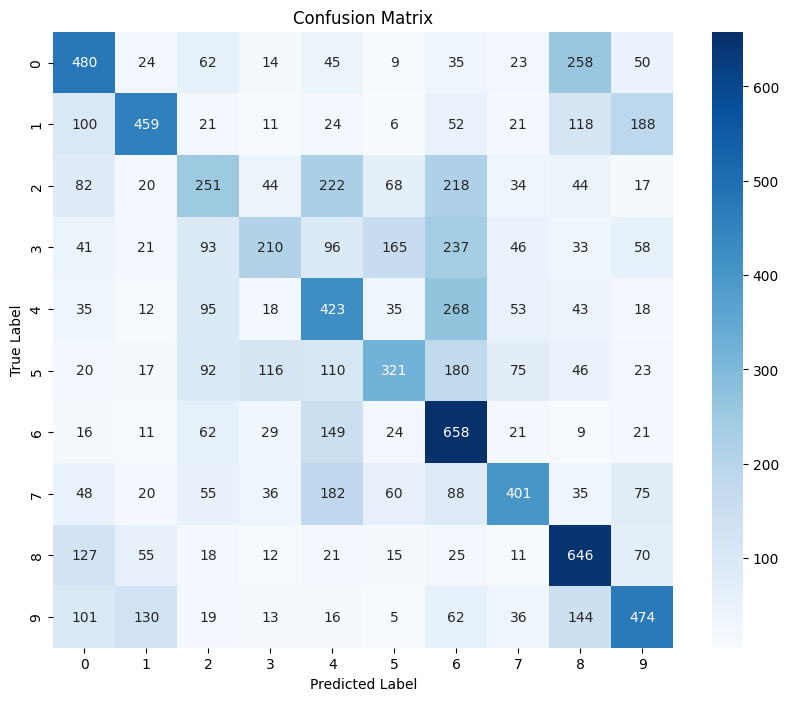

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
